# Task 2: Credit card detection

- Develop a machine learning model designed to detect fraudulent credit card
transactions.

- The process involves preprocessing and normalizing transaction data, addressing class imbalance concerns, and partitioning the dataset into training and testing subsets.

- Train a classification algorithm—like logistic regression or random forests—to
differentiate between fraudulent and legitimate transactions.

- Assess the model's efficacy using metrics such as precision, recall, and F1-score.

- Additionally, explore strategies like oversampling or undersampling to enhance
outcomes and refine the model's performance.

# Credit Card Fraud Detection Dataset

## Overview
This dataset comprises anonymized credit card transactions, each labeled as either fraudulent or genuine. The primary aim is to facilitate the detection of fraudulent credit card transactions to prevent customers from being charged for unauthorized purchases.

## Context
Credit card companies rely on robust fraud detection mechanisms to safeguard customers from fraudulent transactions. Detecting and preventing fraudulent activities is crucial for maintaining trust and security in financial transactions.

## Content
- The dataset contains credit card transactions made by European cardholders in September 2013.
- Transactions span over two days, with a total of 284,807 transactions.
- Among these transactions, there are 492 instances of fraud.
- The dataset exhibits significant class imbalance, with fraudulent transactions accounting for only 0.172% of the total.
- Features include numerical inputs resulting from a Principal Component Analysis (PCA) transformation. However, due to confidentiality constraints, the original features and additional background information are not provided.
- Features V1 to V28 represent principal components obtained through PCA, while 'Time' and 'Amount' are original features.
- The 'Time' feature denotes the elapsed time in seconds between each transaction and the first transaction in the dataset.
- The 'Amount' feature indicates the transaction amount.
- The response variable, 'Class', takes a value of 1 for fraudulent transactions and 0 otherwise.

## Recommendations
- Given the class imbalance, it's advisable to evaluate model performance using metrics such as the Area Under the Precision-Recall Curve (AUPRC).
- Accuracy metrics derived from a confusion matrix may not be meaningful due to the imbalance in class distribution.

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_profiling import ProfileReport
from sklearn.metrics import (accuracy_score, classification_report, 
                             precision_recall_curve, average_precision_score, 
                             roc_curve, auc, confusion_matrix, make_scorer, 
                             precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline

Retrieving data from Kaggle API, (using local machine)

In [2]:
# Local PC data retrieving
from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Download the dataset
api.dataset_download_files('mlg-ulb/creditcardfraud', path='D:/Estiven/Datos/Proyectos/CognoRise_Infotech/data/raw', unzip=True)

# Read the data as a pandas dataframe
df = pd.read_csv("D:/Estiven/Datos/Proyectos/CognoRise_Infotech/data/raw/creditcard.csv")

Retrieving data from Kaggle API, (using Google Colab)

In [3]:
# # Google Colab data retrieving
# from google.colab import files

# # Uploading the Kaggle API key (kaggle.json) to Colab
# files.upload()

# # Move the uploaded file to the required location of Colab
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d mlg-ulb/creditcardfraud #dataset download
# !unzip -q creditcardfraud.zip #unzipping the data

# df = pd.read_csv("creditcard.csv") #reading data as pandas dataframe

Separating the dataframe into the slices I will use to analyze the data and undertand it

In [4]:
data_3_principal = df[['Time', 'Amount', 'Class']]
fraudulent_transactions = df[df['Class'] == 1]
not_fraudulent_transactions = df[df['Class'] == 0]

Profile report of the dataset, overview and relationships between Time, Amount and Class variables

In [5]:
pf_3_variables = ProfileReport(data_3_principal)
pf_3_variables.to_file("D:/Estiven/Datos/Proyectos/CognoRise_Infotech/reports/3_variables_report.html")
pf_3_variables

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
pf_fraudulent_trans = ProfileReport(fraudulent_transactions[['Time', 'Amount']])
pf_fraudulent_trans.to_file("D:/Estiven/Datos/Proyectos/CognoRise_Infotech/reports/fraudulent_transactions_report.html")
pf_fraudulent_trans

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# EDA, (Exploratory data analysis)

Information about nulls, infinite values and duplicates on the data

In [7]:
inf_values = np.isinf(df)
inf_rows, inf_cols = np.where(inf_values)

nulls = df.isnull()
null_rows, null_cols = np.where(nulls)

print(f'Total of null data: {df.isnull().sum().sum()}')
print(f'Total of duplicated data: {df.duplicated().sum()}')

print(f'Rows with null values: {null_rows.sum()}')
print(f'Columns with null values: {null_cols.sum()}')

print(f'Rows with inf values: {inf_rows.sum()}')
print(f'Columns with inf values: {inf_cols.sum()}')

Total of null data: 0
Total of duplicated data: 1081
Rows with null values: 0
Columns with null values: 0
Rows with inf values: 0
Columns with inf values: 0


Duplicates treatment, four percent of the data of Class1 are duplicate rows so I decide to eliminate all those rows to not interfere in the following analysis and ML model

In [8]:
duplicated_rows = df.duplicated()
duplicated_class_1_rows = duplicated_rows & (df['Class'] == 1)

print(f'Percentage of total duplicated data: {duplicated_rows.mean() * 100:.1f}%')
print(f'Total duplicates of the Class 1: {duplicated_class_1_rows.sum()}')
print(f'Percentage of duplicates of Class 1: {duplicated_class_1_rows.sum() / df["Class"].sum() * 100:.1f}%')

# Eliminating duplicated data
df = df.copy().drop_duplicates()

Percentage of total duplicated data: 0.4%
Total duplicates of the Class 1: 19
Percentage of duplicates of Class 1: 3.9%


In [9]:
print(f'Total data by class: {df["Class"].value_counts()}')

Total data by class: Class
0    283253
1       473
Name: count, dtype: int64


In [10]:
percentage_data_by_class = df['Class'].value_counts(normalize=True)
print(f'Percentage of data by class: \n{percentage_data_by_class}')

Percentage of data by class: 
Class
0    0.998333
1    0.001667
Name: proportion, dtype: float64


There are not correlations between variables grater or equal than 0.7, but there is one grater or equal than 0.5, which is between `Amount` and `V2`. Therefore when we apply the fueature importance part, the correlations now make more sense and there are many variables correlated, we will see it in further cells.

In [11]:
corr = df.corr()

# Filtering correlations
high_corr_pairs = []
correlation_value = 0.5
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) >= correlation_value:
            high_corr_pairs.append((corr.columns[i], corr.columns[j]))

print(f"Pairs of variables with a correlation greater than {correlation_value}:")
for pair in set(high_corr_pairs):
    print(pair)

Pairs of variables with a correlation greater than 0.5:
('Amount', 'V2')


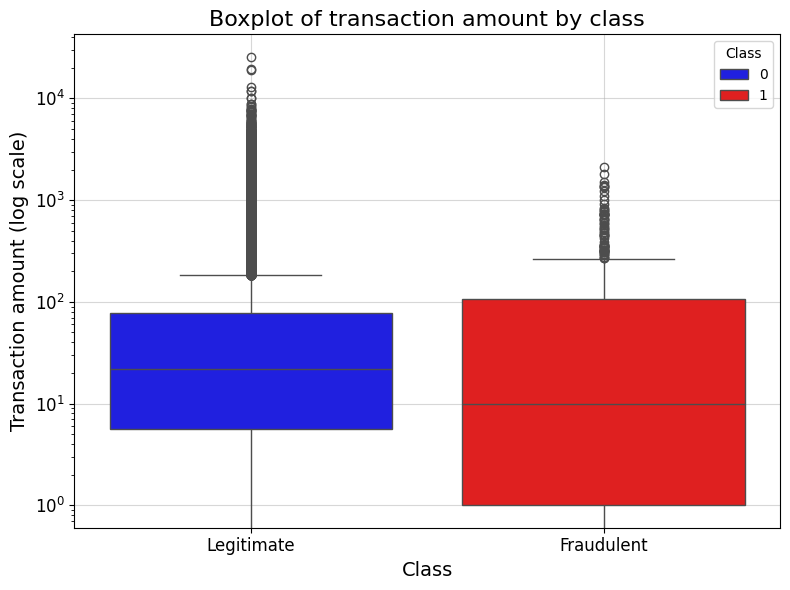

In [12]:
# Distribution of the 'Amount' feature
plt.figure(figsize=(8, 6))

# Create the boxplot with distinct colors for each class
sns.boxplot(x='Class', y='Amount', data=df, hue='Class', palette=['blue', 'red'])

# Add labels and title
plt.title('Boxplot of transaction amount by class', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Transaction amount (log scale)', fontsize=14)
plt.xticks([0, 1], ['Legitimate', 'Fraudulent'], fontsize=12)
plt.yticks(fontsize=12)

plt.yscale('log') # Use a log scale for the y-axis
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

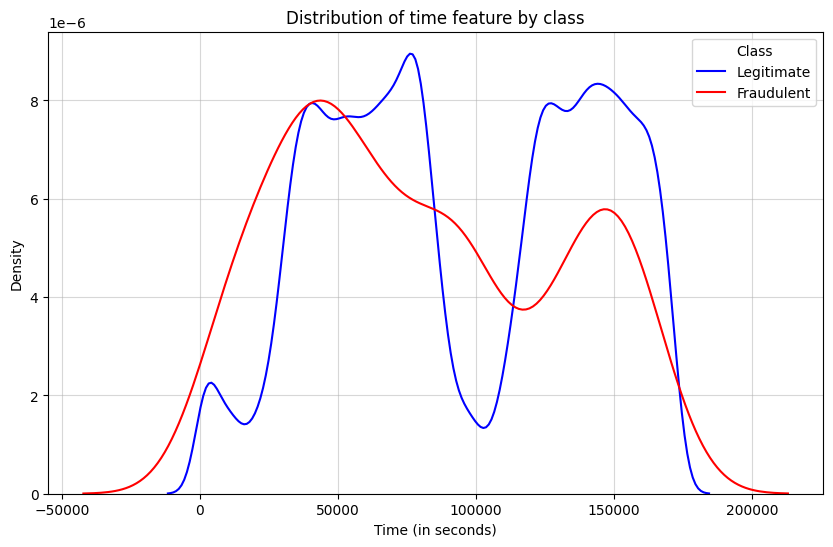

In [13]:
# Density plots for the 'Time' feature by class
plt.figure(figsize=(10, 6))

sns.kdeplot(df[df['Class'] == 0]['Time'], color='blue', label='Legitimate')
sns.kdeplot(df[df['Class'] == 1]['Time'], color='red', label='Fraudulent')

# Add labels and title
plt.xlabel('Time (in seconds)')
plt.ylabel('Density')
plt.title('Distribution of time feature by class')
plt.legend(title='Class')
plt.grid(True, alpha=0.5)

plt.show()

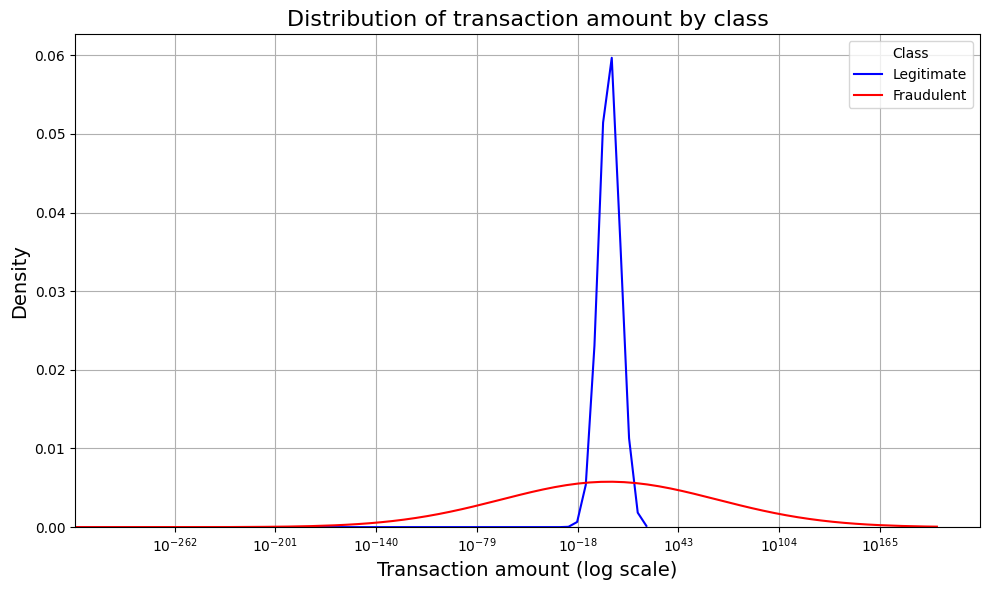

In [14]:
plt.figure(figsize=(10, 6))

plt.xscale('log') # Use a log scale for the y-axis
# Use density plots instead of histograms
sns.kdeplot(df[df['Class'] == 0]['Amount'], color='blue', label='Legitimate')
sns.kdeplot(df[df['Class'] == 1]['Amount'], color='red', label='Fraudulent')

# Add a grid
plt.grid(True)

# Add labels and title
plt.title('Distribution of transaction amount by class', fontsize=16)
plt.xlabel('Transaction amount (log scale)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Class')

plt.tight_layout()
plt.show()

Imbalaced data traetment, (three different methods)

In [15]:
def handle_imbalanced_data(dataset: pd.DataFrame, method: str='over_sampling', target_col: str='Class'):
    """
    Handle imbalanced data in a dataset.

    Parameters:
    dataset (DataFrame): The input dataset which is imbalanced.
    method (str): The method to handle imbalanced data. It can be 'over_sampling', 'under_sampling', 'smote'. Default is 'over_sampling'.
    target_col (str): The name of the target variable column. Default is 'Class'.

    Returns:
    DataFrame: The balanced dataset.
    """
    # Get the counts of each class
    count_class_0, count_class_1 = dataset[target_col].value_counts()

    # Divide the dataset by class
    df_class_0 = dataset[dataset[target_col] == 0]
    df_class_1 = dataset[dataset[target_col] == 1]

    # Oversampling: Oversample 1-class and concat the DataFrames of both classes
    if method == 'over_sampling':
        df_class_1_over = df_class_1.sample(count_class_0, replace=True)
        return pd.concat([df_class_0, df_class_1_over], axis=0)

    # Undersampling: Undersample 0-class and concat the DataFrames of both classes
    elif method == 'under_sampling':
        df_class_0_under = df_class_0.sample(count_class_1)
        return pd.concat([df_class_0_under, df_class_1], axis=0)

    # SMOTE: Use SMOTE to oversample the minority class
    elif method == 'smote':
        smote = SMOTE(random_state=42)
        X = dataset.drop(target_col, axis=1)
        y = dataset[target_col]
        X_sm, y_sm = smote.fit_resample(X, y)
        X_sm_df, y_sm_df = pd.DataFrame(X_sm, columns=X.columns), pd.DataFrame(y_sm, columns=[target_col])
        df_sm = pd.concat([X_sm_df, y_sm_df], axis=1)
        return df_sm

    else:
        raise ValueError("Invalid method. It should be 'over_sampling', 'under_sampling', 'smote' ... ")


In [16]:
for method in ['over_sampling', 'under_sampling', 'smote']:
    balanced_data = handle_imbalanced_data(df, method=method, target_col='Class')
    class_counts = balanced_data['Class'].value_counts()
    print(f'Balanced data using {method} method: \n{class_counts}\n')

Balanced data using over_sampling method: 
Class
0    283253
1    283253
Name: count, dtype: int64

Balanced data using under_sampling method: 
Class
0    473
1    473
Name: count, dtype: int64

Balanced data using smote method: 
Class
0    283253
1    283253
Name: count, dtype: int64



Normalization of the data, I choose RobustScaler since the data I'm dealing with is full of outliers

In [17]:
# Initialize the scaler
scaler = RobustScaler()

# Scale the 'Amount' and 'Time' columns and drop its original columns
df_scaled = df.copy()
df_scaled[['Amount_normalized', 'Time_normalized']] = scaler.fit_transform(df[['Amount', 'Time']])

df_scaled.drop(['Amount', 'Time'], axis=1, inplace=True)
df_scaled.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Amount_normalized,Time_normalized
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,-0.001441,...,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,0.001667,0.924387,0.118912
std,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,1.076407,...,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,0.040796,3.482123,0.557988
min,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,...,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,-0.305938,-0.995290
25%,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,-0.535578,...,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,0.000000,-0.228063,-0.358286
50%,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,-0.093237,...,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,0.000000,0.000000,0.000000
75%,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,0.453619,...,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,0.000000,0.771937,0.641714
max,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,...,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,1.000000,356.962314,1.035329


In [18]:
# Model to train
model = RandomForestClassifier()

# Perform training for each model
for method in ['over_sampling', 'under_sampling', 'smote']:
    balanced_data = handle_imbalanced_data(df_scaled, method=method)
    X = balanced_data.drop('Class', axis=1)
    y = balanced_data['Class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Classification report for {method} and {model.__class__.__name__}: \n{classification_report(y_test, y_pred)}")
    print('\n')

Classification report for over_sampling and RandomForestClassifier: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84888
           1       1.00      1.00      1.00     85064

    accuracy                           1.00    169952
   macro avg       1.00      1.00      1.00    169952
weighted avg       1.00      1.00      1.00    169952



Classification report for under_sampling and RandomForestClassifier: 
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       140
           1       0.97      0.91      0.94       144

    accuracy                           0.94       284
   macro avg       0.94      0.94      0.94       284
weighted avg       0.94      0.94      0.94       284



Classification report for smote and RandomForestClassifier: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84880
           1       1.00      1.00

As there are highly correlated variables, I can assure that there can be made a feature importance technique for dimensionality reduction in the dataset

In [19]:
balanced_data = handle_imbalanced_data(df_scaled, method='under_sampling')
X = balanced_data.drop('Class', axis=1)
y = balanced_data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

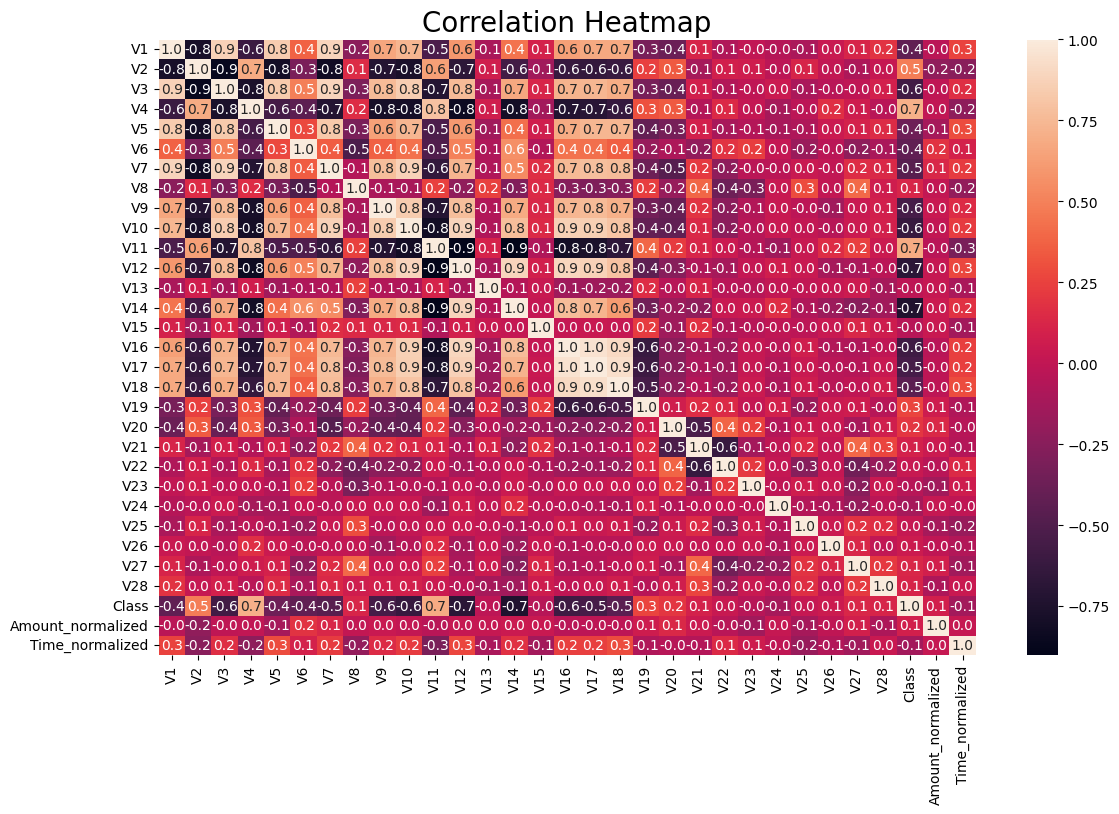

Pairs of variables with a correlation greater than 0.7:
Number of pairs: 63


In [20]:
# Compute the correlation matrix
corr_under_sampling = balanced_data.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_under_sampling, annot=True, fmt=".1f")
plt.tight_layout()

plt.title('Correlation Heatmap', fontsize=20)
plt.show()

corr_smote = balanced_data.corr()

# Filtering correlations
high_corr_pairs = []
correlation_value = 0.7
for i in range(len(corr_smote.columns)):
    for j in range(i):
        if abs(corr_smote.iloc[i, j]) >= correlation_value:
            high_corr_pairs.append((corr_smote.columns[i], corr_smote.columns[j]))

print(f"Pairs of variables with a correlation greater than {correlation_value}:")
print(f'Number of pairs: {len(set(high_corr_pairs))}')

In [25]:
# Define the parameter grid
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [1, 3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Initialize the classifier
rf = RandomForestClassifier()

# Use stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=3)

# Initialize the random search
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, cv=cv, n_jobs=-1, n_iter=10)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_

# Train the model using the best parameters
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = best_model.predict(X_train)

# Predict on the test set
y_test_pred = best_model.predict(X_test)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_test_pred)

# Print the metrics
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"ROC AUC Score: {roc_auc}")

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Print the classification report
print(f"Classification report for {best_model.__class__.__name__}: \n{classification_report(y_test, y_test_pred)}")

# Print the best parameters
print('Best params:', best_params)

Train Accuracy: 0.9773413897280967
Test Accuracy: 0.9471830985915493
ROC AUC Score: 0.9475198412698412
Confusion Matrix:
[[136   4]
 [ 11 133]]
Classification report for RandomForestClassifier: 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       140
           1       0.97      0.92      0.95       144

    accuracy                           0.95       284
   macro avg       0.95      0.95      0.95       284
weighted avg       0.95      0.95      0.95       284

Best params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 10, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}


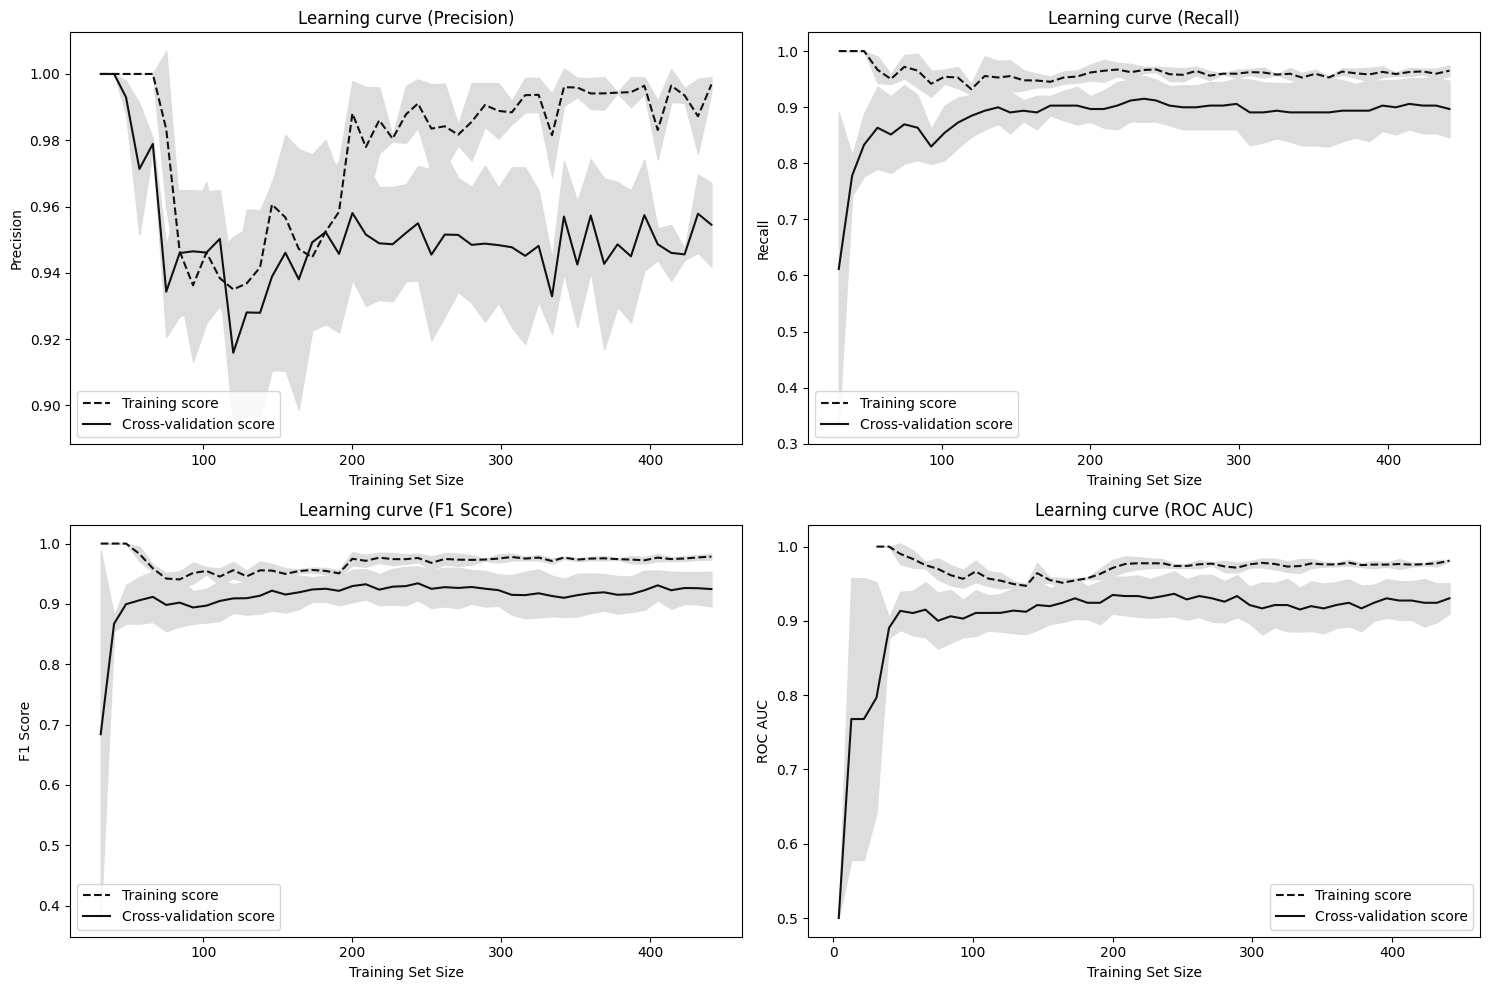

In [37]:
# Define the metrics
metrics = {
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'F1 Score': make_scorer(f1_score),
    'ROC AUC': make_scorer(roc_auc_score)
}

# Create a figure
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Flatten the axes
axs = axs.ravel()

# For each metric
for i, (metric_name, metric) in enumerate(metrics.items()):
    # Create CV training and test scores for various training set sizes
    train_sizes, train_scores, test_scores = learning_curve(best_model, 
                                                            X_train, 
                                                            y_train,
                                                            cv=StratifiedKFold(n_splits=3),
                                                            scoring=metric,
                                                            n_jobs=-1, 
                                                            train_sizes=np.linspace(0.01, 1.0, 50))

    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Draw lines
    axs[i].plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    axs[i].plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

    # Draw bands
    axs[i].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    axs[i].fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    # Create plot
    axs[i].set_title(f"Learning curve ({metric_name})")
    axs[i].set_xlabel("Training Set Size")
    axs[i].set_ylabel(metric_name)
    axs[i].legend(loc="best")

plt.tight_layout()
plt.show()

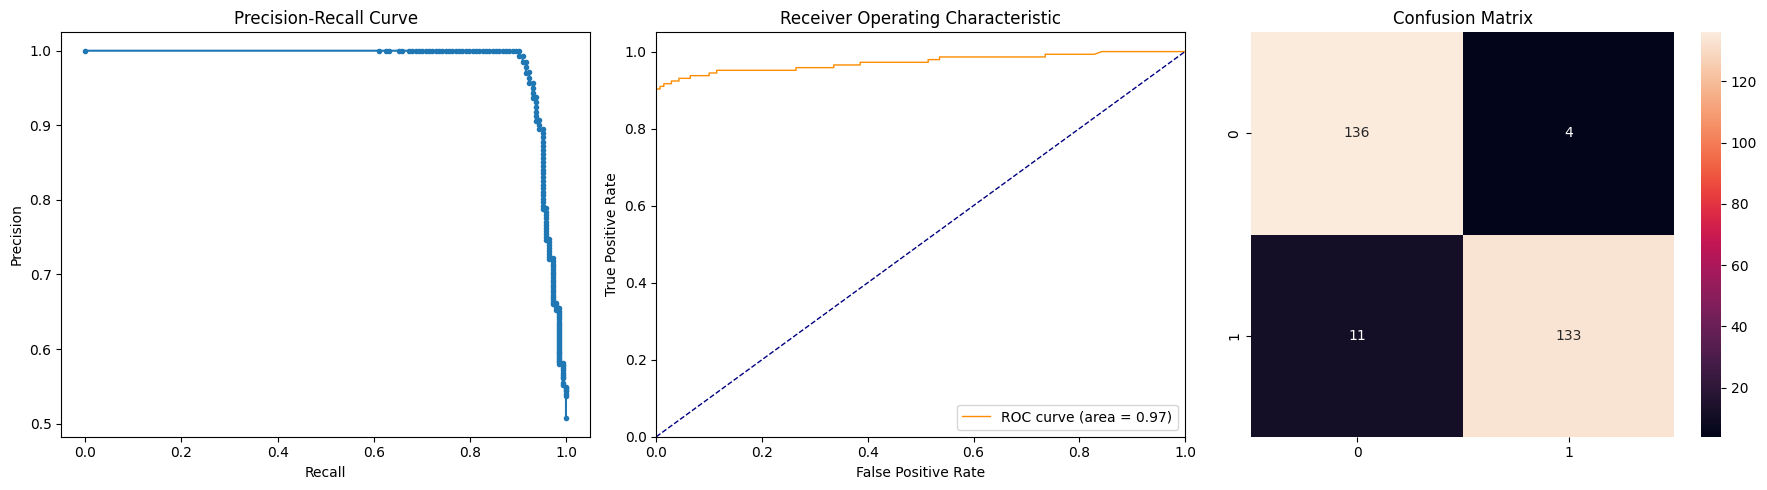

Area under the precision-recall curve: 0.97
Average precision-recall score: 0.98


In [36]:
# Compute precision-recall pairs for different probability thresholds
y_score = best_model.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_score)

# Plot Precision-Recall curve
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.subplot(1,3,2)
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic, ROC Curve')
plt.legend(loc="lower right")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot Confusion Matrix
plt.subplot(1,3,3)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

# Area under the precision-recall curve
print('Area under the precision-recall curve: {0:0.2f}'.format(roc_auc))

# Compute the average precision score
average_precision = average_precision_score(y_test, y_score)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))